In [6]:
import pandas as pd
import requests
from Bio.KEGG import Enzyme
import matplotlib
import io
import time
import pickle
import re
from rich.progress import Progress
from rdkit import Chem
from collections import Counter
import rdkit.Chem as Chem
from rdkit.Chem import BRICS,Recap, rdFMCS
from rdkit.Chem import Draw


def get_parity_score(mol1, mol2, print_structures = False, ringmatches = False,returnmcs = True):
    # Get the MCS of the two molecules
    print("getting mcs")
    mcs_result = rdFMCS.FindMCS(
        [mol1, mol2], 
        matchValences=False,
        ringMatchesRingOnly= ringmatches,
        atomCompare=rdFMCS.AtomCompare.CompareAny, 
        bondCompare=rdFMCS.BondCompare.CompareAny, timeout = 250)
    # Convert the SMARTS string from the MCS result into a molecule
    print("got mcs")
    if mcs_result.canceled:
        print("cancelled")
    mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
    # Map the MCS back onto the original molecules and get the atom indices
    mol1_match = mol1.GetSubstructMatch(mcs_mol)
    mol2_match = mol2.GetSubstructMatch(mcs_mol)
    
    from rdkit.Chem import Draw
    if print_structures:
        # Draw the molecules and the MCS
        Draw.MolToMPL(mol1, size=(200,200), kekulize=True, title='Molecule 1')
        Draw.MolToMPL(mol2, size=(200,200), kekulize=True, title='Molecule 2')
        Draw.MolToMPL(mcs_mol, size=(200,200), kekulize=True, title='MCS')
    # Compare the atom types at each matched position
    Nsim = 0
    for idx1, idx2 in zip(mol1_match, mol2_match):
        atom1 = mol1.GetAtomWithIdx(idx1)
        atom2 = mol2.GetAtomWithIdx(idx2)
        if atom1.GetAtomicNum() == atom2.GetAtomicNum():
            Nsim += 1

    # Compute PARITY similarity score
    NB = mol1.GetNumAtoms()
    NC = mol2.GetNumAtoms()
    score = Nsim / (NB + NC - Nsim)
    if returnmcs:
        return score, mcs_mol
    else:
        return score

Need to refactor the KEGG scraping to get the following : 
* EC number to KEGG Enzyme mapping.
* KEGG Enzyme mapping to reaction number(s).
* Reaction numbers to reactants.

These should be formatted so that for an EC number, the reactants to query can be easily accessed.

Currently, EC numbers hold a BioPython KEGG Enzyme record. Should switch this or have an additional store of a pandas dataframe containing just the reaction numbers. Can explode/have multiple lines of EC numbers in the df where there are multiple reactions associated. 

In [5]:
reaction = []

for enzyme_name, enzyme_record in enzyme_dict.items():
    record_info = {"enzyme": enzyme_name, "reaction":enzyme_record.reaction}
    rn_numbers = []
    products_substrates = []
    for reaction_str in enzyme_record.reaction:
        rn_numbers.extend(re.findall(r'\[RN:(R\d+)\]', reaction_str))
    record_info["rn_numbers"] = rn_numbers
    for rn_number in rn_numbers:
        react = reaction_dictionary[rn_number]
        equation = react['equation'][0]
        products_substrates.extend(re.findall(r'\b[C|G]\d+\b', equation))
    record_info["products_substrates"] = products_substrates
        
    reaction.append(record_info)

    

reaction_df = pd.DataFrame(reaction)

When a compound is a generic compound, we should match everything we can find but should also flag the fact we are searching on a generic compound.

In [6]:
inchi_ligands = pd.read_csv("inchi_ligands.csv") #load the unique ligand inchi descriptors in
inchi_ligands["protein_polymer_EC"] = inchi_ligands["protein_polymer_EC"].str.split(",") #where the unique inchi descriptors are associated with multiple ECs, split the column
inchi_ligands_exploded = inchi_ligands.explode("protein_polymer_EC") #explode on this list
inchi_ligands_exploded_unique_pairs = inchi_ligands_exploded.drop_duplicates(["inchi_descriptor","protein_polymer_EC"]) #get the unique pairs of inchi descriptors and EC numbers

In [7]:
inchi_ligands_exploded_unique_pairs

,pdb_entry_id,ligand_entity_id,inchi_descriptor,protein_polymer_EC
0,1dmi,1dmi_6,InChI=1S/C9H15N5O3/c1-3(15)6(16)4-2-11-7-5(12-...,1.14.13.39
1,5owl,5owl_2,InChI=1S/C10H9Br4N3/c11-5-6(12)8(14)10-9(7(5)1...,2.7.11.1
3,5k9c,5k9c_4,"InChI=1S/C21H21F3N2O3/c22-21(23,24)29-16-10-8-...",1.3.5.2
4,1lpz,1lpz_4,InChI=1S/C25H22Cl2N4O/c1-15-4-2-7-22-21(15)12-...,3.4.21.6
5,5g2t,5g2t_6,InChI=1S/C6H8O9S/c7-2-1-3(5(8)9)14-6(10)4(2)15...,3.1.6.18
...,...,...,...,...
144296,3bhe,3bhe_2,"InChI=1S/C23H32N2O3S/c1-19(2)15-25(29(26,27)23...",3.4.23.16
144297,3wk4,3wk4_4,InChI=1S/C12H16N2O/c1-9(10-7-8-10)13-12(15)14-...,3.3.2.10
144297,3wk4,3wk4_4,InChI=1S/C12H16N2O/c1-9(10-7-8-10)13-12(15)14-...,3.1.3.76
144298,4lvb,4lvb_2,InChI=1S/C12H14N2O2/c1-8(15)13-10-4-6-11(7-5-1...,2.4.2.12


In [2]:
test_sugar = Chem.MolFromMolBlock(""" 
 
 
 46 47  0  0  1  0  0  0  0  0999 V2000
   15.9666  -18.9599    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   15.9337  -17.5704    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   14.6552  -19.6363    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   17.0731  -19.6917    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   17.1379  -16.9034    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   14.7200  -16.8477    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   13.4603  -20.3126    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   18.3146  -19.0155    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   17.0361  -21.0907    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   18.3516  -17.6260    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   13.5250  -17.5795    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   12.2464  -19.5899    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   13.4138  -21.7206    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   19.5096  -19.7567    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   19.5838  -16.9684    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   11.0238  -20.2570    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   12.1817  -22.3786    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   14.4327  -22.2303    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   20.8066  -17.6631    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   10.9958  -21.6650    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
    9.8285  -19.5342    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   12.1446  -23.7866    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   22.0202  -16.9404    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
    9.7361  -22.3415    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
    8.6335  -20.2570    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   23.2614  -17.6351    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   22.0108  -15.5323    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   24.4844  -16.9128    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   23.2708  -19.0435    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   23.2152  -14.8191    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   25.7073  -17.6074    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   23.2666  -13.4107    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   24.4473  -15.5044    0.0000 R   0  0  0  0  0  0  0  0  0  0  0  0
   26.9207  -16.8942    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   28.1529  -17.5889    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   29.3758  -16.8663    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   30.5987  -17.5610    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   31.8216  -16.8386    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   33.0537  -17.5242    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   34.2672  -16.8107    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   35.4993  -17.5056    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   36.7128  -16.7921    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   37.9543  -17.4777    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   39.1678  -16.7736    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   40.4001  -17.4591    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   41.6137  -16.7459    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0     0  0
  1  3  1  6     0  0
  1  4  1  0     0  0
  2  5  1  0     0  0
  2  6  1  1     0  0
  7  3  1  1     0  0
  4  8  1  0     0  0
  4  9  1  1     0  0
  5 10  1  0     0  0
  6 11  1  0     0  0
  7 12  1  0     0  0
  7 13  1  0     0  0
  8 14  1  6     0  0
 10 15  1  1     0  0
 12 16  1  0     0  0
 13 17  1  0     0  0
 13 18  1  6     0  0
 15 19  1  0     0  0
 16 20  1  0     0  0
 16 21  1  1     0  0
 17 22  1  1     0  0
 19 23  1  0     0  0
 20 24  1  1     0  0
 21 25  1  0     0  0
 23 26  1  0     0  0
 23 27  1  6     0  0
 26 28  1  0     0  0
 26 29  1  1     0  0
 27 30  1  0     0  0
 28 31  2  0     0  0
 30 32  2  0     0  0
 30 33  1  0     0  0
 31 34  1  0     0  0
 34 35  1  0     0  0
 35 36  1  0     0  0
 36 37  1  0     0  0
 37 38  1  0     0  0
 38 39  1  0     0  0
 39 40  1  0     0  0
 40 41  1  0     0  0
 41 42  1  0     0  0
 42 43  1  0     0  0
 43 44  1  0     0  0
 44 45  1  0     0  0
 45 46  1  0     0  0
  8 10  1  0     0  0
 17 20  1  0     0  0
M  END""")

test_sugar = Chem.MolFromMolBlock(""" 
 
 
 22 22  0  0  1  0  0  0  0  0999 V2000
   24.2148  -21.4379    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   24.2148  -22.8420    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   25.4324  -20.7447    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   22.9971  -20.7447    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   25.4324  -23.5469    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   22.9971  -23.5469    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   26.6383  -21.4379    0.0000 C   0  0  3  0  0  0  0  0  0  0  0  0
   23.0029  -19.3405    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   21.7852  -21.4379    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   26.6383  -22.8420    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   25.4324  -24.9450    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   23.0029  -24.9391    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   27.6287  -20.4418    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   27.9840  -21.7991    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   21.7852  -18.6357    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   24.2148  -18.6357    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   21.7969  -25.6382    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   24.2088  -25.6325    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   28.9861  -20.7971    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   27.2499  -19.0902    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   21.7852  -17.2374    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   23.0024  -22.1379    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0     0  0
  1  3  1  0     0  0
  1  4  1  0     0  0
  2  5  1  0     0  0
  2  6  1  1     0  0
  3  7  1  0     0  0
  4  8  1  0     0  0
  4  9  1  6     0  0
  5 10  1  0     0  0
  5 11  1  6     0  0
  6 12  1  0     0  0
  7 13  1  4     0  0
  7 14  1  0     0  0
  8 15  1  0     0  0
  8 16  1  1     0  0
 12 17  1  0     0  0
 12 18  2  0     0  0
 13 19  1  0     0  0
 13 20  2  0     0  0
 15 21  1  0     0  0
  7 10  1  0     0  0
  1 22  1  1     0  0
M  END""")

oseltamivir_inchi = "InChI=1S/C16H28N2O4/c1-5-12(6-2)22-14-9-11(16(20)21-7-3)8-13(17)15(14)18-10(4)19/h9,12-15H,5-8,17H2,1-4H3,(H,18,19)/t13-,14+,15+/m0/s1" 

getting mcs
got mcs
0.4827586206896552
getting mcs
got mcs
0.2222222222222222
getting mcs
got mcs
0.2222222222222222
getting mcs
got mcs
0.11538461538461539
getting mcs
got mcs
0.16
getting mcs
got mcs
0.0
getting mcs
got mcs
0.0
getting mcs
got mcs
0.08333333333333333
getting mcs
got mcs
0.08333333333333333
getting mcs
got mcs
0.04
getting mcs
got mcs
0.04
getting mcs
got mcs


TypeError: cannot unpack non-iterable float object

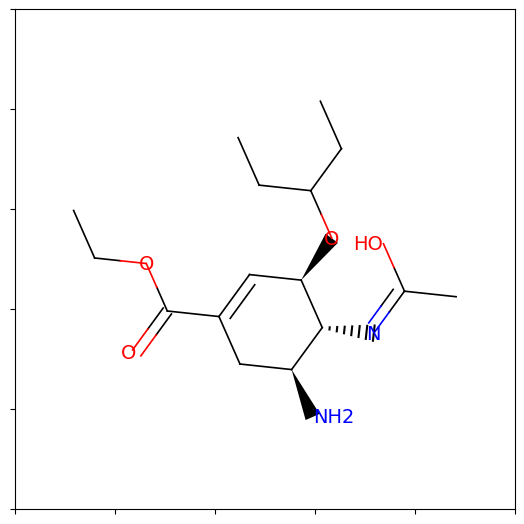

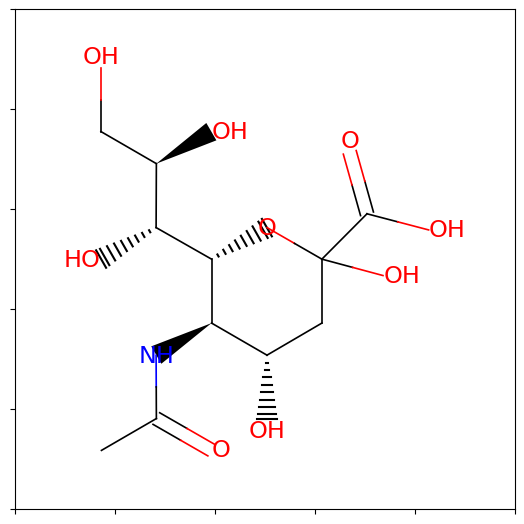

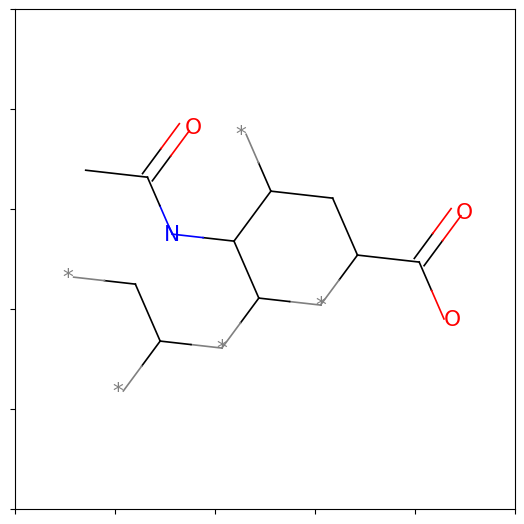

In [3]:
oseltamivir = Chem.MolFromInchi(oseltamivir_inchi)
Chem.MolToSmiles(test_sugar)

pieces = Chem.BRICS.BRICSDecompose(test_sugar) 
fragmented=BRICS.BreakBRICSBonds(test_sugar)
pieces=Chem.GetMolFrags(fragmented,asMols=True)
Draw.MolsToGridImage(pieces)

print(get_parity_score(oseltamivir, test_sugar, print_structures = True, ringmatches = True))
for piece in pieces: 
    print(get_parity_score(oseltamivir, piece, ringmatches =False))
    print(get_parity_score(oseltamivir, piece, ringmatches =True))
    
pieces = Recap.RecapDecompose(test_sugar)
smiles_pieces = []
for smiles, recap in pieces.children.items():
    smiles_pieces.append(Chem.MolFromSmiles(smiles))

In [18]:
score, struct = get_parity_score(oseltamivir,test_sugar)

num_atoms_mol1 = test_sugar.GetNumAtoms()
num_atoms_mol2 = oseltamivir.GetNumAtoms()
num_atoms_mcs = struct.GetNumAtoms()

print(num_atoms_mol1, num_atoms_mol2, num_atoms_mcs)

getting mcs
got mcs
21 22 19


In [26]:
score

0.4827586206896552

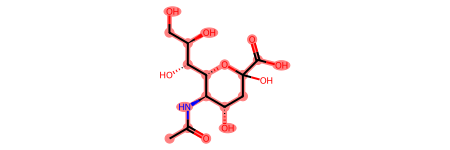

In [19]:
test_sugar

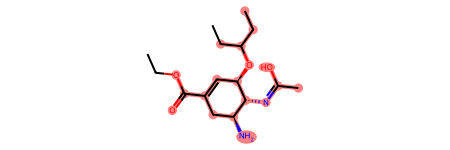

In [20]:
oseltamivir

In [27]:
sugar = Chem.MolFromMolBlock(""" 
 
 
 23 24  0  0  1  0  0  0  0  0999 V2000
   27.4952  -17.6709    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   27.4952  -16.2679    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   26.2844  -18.3695    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   28.7120  -18.3638    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   28.7120  -15.5692    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   26.2844  -15.5633    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   25.0735  -19.0682    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   29.9231  -17.6709    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   28.7120  -19.7668    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   29.9231  -16.2679    0.0000 C   0  0  3  0  0  0  0  0  0  0  0  0
   25.0735  -16.2679    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   23.8684  -18.3638    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   25.0735  -20.4712    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   31.1340  -18.3638    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   31.1340  -15.5692    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   22.6516  -19.0682    0.0000 C   0  0  1  0  0  0  0  0  0  0  0  0
   23.8684  -21.1641    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   26.2844  -21.1641    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   22.6516  -20.4712    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   21.4348  -18.3638    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   23.8684  -22.5671    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   21.4348  -21.1641    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   20.2239  -19.0682    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0     0  0
  1  3  1  6     0  0
  1  4  1  0     0  0
  2  5  1  0     0  0
  2  6  1  1     0  0
  7  3  1  6     0  0
  4  8  1  0     0  0
  4  9  1  1     0  0
  5 10  1  0     0  0
  6 11  1  0     0  0
  7 12  1  0     0  0
  7 13  1  0     0  0
  8 14  1  6     0  0
 10 15  1  4     0  0
 12 16  1  0     0  0
 13 17  1  0     0  0
 13 18  1  6     0  0
 16 19  1  0     0  0
 16 20  1  1     0  0
 17 21  1  1     0  0
 19 22  1  6     0  0
 20 23  1  0     0  0
  8 10  1  0     0  0
 17 19  1  0     0  0
M  END""")

inhibitor = Chem.MolFromMolBlock(""" 
 
 
 11 11  0  0  1  0  0  0  0  0999 V2000
   21.6300  -17.9200    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   21.6300  -19.3200    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   22.8424  -20.0200    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   24.0549  -19.3200    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   24.0549  -17.9200    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   22.8424  -17.2200    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   20.4176  -17.2200    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   19.2221  -17.9104    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   20.4176  -20.0200    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   25.2860  -20.0310    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   22.8424  -21.4198    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0     0  0
  2  3  1  0     0  0
  3  4  1  0     0  0
  4  5  1  0     0  0
  5  6  1  0     0  0
  1  6  1  0     0  0
  1  7  1  1     0  0
  7  8  1  0     0  0
  2  9  1  6     0  0
  4 10  1  6     0  0
  3 11  1  1     0  0
M  END""")

score, struct = get_parity_score(sugar, inhibitor, ringmatches =True)


score
sugar_name = "cellobiose"
inhibitor_name = "duvoglustat"

num_atoms_mol1 = sugar.GetNumAtoms()
num_atoms_mol2 = inhibitor.GetNumAtoms()
num_atoms_mcs = struct.GetNumAtoms()

print(num_atoms_mol1, num_atoms_mol2, num_atoms_mcs)

getting mcs
got mcs
23 11 11


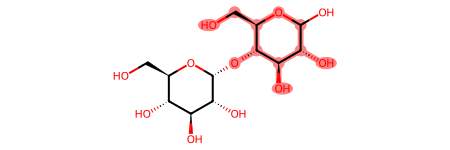

In [29]:
sugar

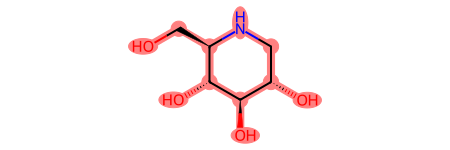

In [30]:
inhibitor

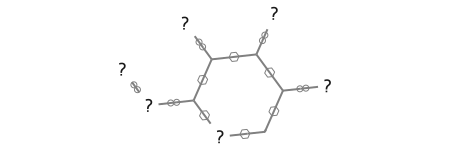

In [28]:
struct

In [31]:
score

0.4166666666666667

find examples of suggars where there is fundamentally different recognition protein due to a single linkage difference